# Resizing and padding

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
import os
from os.path import join,exists
from tensorboard import program
import datetime
import numpy as np
import pandas as pd
import cv2
import pickle
from tqdm import tqdm
from PIL import Image
from random import randint
import matplotlib.pyplot as plt

import tensorflow as tf



from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from tensorflow.keras.models import  load_model,Model
from tensorflow.keras import applications
from tensorflow.keras.layers import Lambda,Input,Dropout, Activation, Dense, GlobalMaxPooling2D,Conv2D,Flatten,MaxPooling2D,InputLayer
from tensorflow.keras.utils import to_categorical

from efficientnet.tfkeras import EfficientNetB7
from tensorflow.keras import datasets
from foolbox.attacks import LinfFastGradientAttack,LinfDeepFoolAttack
from foolbox.distances import LpDistance
from foolbox.models import TensorFlowModel
from foolbox import criteria
from sklearn.metrics import classification_report,plot_roc_curve

from art.attacks.evasion import SaliencyMapMethod
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import BoundaryAttack
from art.utils import load_dataset #to play with cifar images
from tensorflow.keras.layers.experimental import preprocessing
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4*1024)]
)

In [3]:
tf.config.run_functions_eagerly(True)

## 1. Load Data

In [4]:
data_mnist=datasets.mnist.load_data(path='mnist.npz')
X_train_mnist,y_train_mnist=data_mnist[0][0],data_mnist[0][1]
X_test_mnist,y_test_mnist=data_mnist[1][0],data_mnist[1][1]
y_train_mnist = to_categorical(y_train_mnist, 10)
y_test_mnist = to_categorical(y_test_mnist, 10)

""" Train """
X_train_img_mnist = np.full((60000, 32, 32, 3), 0)
for i, s in enumerate(X_train_mnist):
    X_train_img_mnist[i] = cv2.cvtColor(np.pad(s,2), cv2.COLOR_GRAY2RGB) 
    
""" Test """
X_test_img_mnist = np.full((10000, 32, 32, 3), 0)
for i, s in enumerate(X_test_mnist):
    X_test_img_mnist[i] = cv2.cvtColor(np.pad(s,2), cv2.COLOR_GRAY2RGB) 
    
X_train_mnist=X_train_img_mnist
X_test_mnist= X_test_img_mnist

In [5]:
(X_train_cifar, y_train_cifar), (X_test_cifar, y_test_cifar), _,_=load_dataset('cifar10')
for i, im in enumerate(X_train_cifar):
    X_train_cifar[i]=255*im
for i, im in enumerate(X_test_cifar):
    X_test_cifar[i]=255*im    


dict_classes={}
dict_classes[0]='airplane'
dict_classes[1]='automobile'
dict_classes[2]='bird'
dict_classes[3]='cat'
dict_classes[4]='deer'
dict_classes[5]='dog'
dict_classes[6]='frog'
dict_classes[7]='horse'
dict_classes[8]='ship'
dict_classes[9]='truck'

In [6]:
def pick_data_set(name):
    
    if name=='Mnist':
        X_train=X_train_mnist
        X_test= X_test_mnist
        y_train = y_train_mnist
        y_test= y_test_mnist

    elif name=='Cifar':
        X_train=X_train_cifar
        X_test= X_test_cifar
        y_train = y_train_cifar
        y_test= y_test_cifar    
        
    return(X_train,X_test,y_train,y_test)
    

## 2. Load models

Nous allons comparer les attaques sur efficientNet,VGG   


Afin de tester certaines attaques plus longues (comme JSMA) nous créons également un petit modèle 

### Model with defense

In [7]:
class ResizePad(tf.keras.layers.Layer):
    def __init__(self):
        super(ResizePad,self).__init__()
       
        
    def resize_and_pad(self,image):
        new_size=randint(13,27)
        left_offset=randint(0,32-new_size)
        top_offset=randint(0,32-new_size)
        image=tf.cast(image,dtype='float32')
        paddings = tf.constant([[0,0],[top_offset,32-top_offset-new_size],[left_offset,32-left_offset-new_size],[0,0]])
        image=tf.image.resize(image, [new_size,new_size], method='nearest', preserve_aspect_ratio=True)
        image=tf.pad(image, paddings, mode='CONSTANT', constant_values=0, name=None)
        return(image)
    
    def call(self, x):
        return self.resize_and_pad(x)


In [8]:
def train_and_save_effnet(data_set_name):
    (X_train,X_test,y_train,y_test)=pick_data_set(data_set_name)
    tf.keras.backend.clear_session()
    effnet_base = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    effnet_base.trainable=True
    x = GlobalMaxPooling2D(name='pool_1')(effnet_base.layers[-2].output)
    x = Dropout(0.2, name="dropout_2")(x)
    x = Dense(32)(x)
    x = Dense(10,name='fc_2')(x)
    o = Activation('softmax', name='act_2')(x)
    model_effnet = Model(inputs=effnet_base.input, outputs=[o])


    
    if exists('models/effnet_model_'+str(data_set_name)+'.h5')==False:
        model_effnet.compile(
            loss='categorical_crossentropy',
            optimizer='nadam',
            metrics=['accuracy']
            )
        history = model_effnet.fit(X_train, y_train,
                      epochs=5,
                      batch_size = 128,
                      validation_split=0.1,
                      shuffle=True,
                      verbose=1)
        model_effnet.save('models/effnet_model_'+str(data_set_name)+'.h5')

    else:
        model_effnet=load_model('models/effnet_model_'+str(data_set_name)+'.h5')
        
    return(model_effnet)
    

In [9]:
def create_model_with_defense(data_set_name):

    (X_train,X_test,y_train,y_test)=pick_data_set(data_set_name)
    model_without_def=train_and_save_effnet(data_set_name)
    
    
    model_with_def = tf.keras.models.Sequential()
    model_with_def.add(Input(shape=(32,32,3)))
    model_with_def.add(ResizePad())
    model_with_def.add(model_without_def)


    model_with_def.compile(
        loss='categorical_crossentropy',
        optimizer='nadam',
        metrics=['accuracy']
        )
    if exists('models/random_padding/'+str(data_set_name)+'.h5')==False:
        history = model_with_def.fit(X_train, y_train,
                      epochs=5,
                      batch_size = 32,
                      validation_split=0.1,
                      shuffle=True,
                      verbose=1)
        model_with_def.save_weights('models/random_padding/'+str(data_set_name)+'.h5')
    else:
        model_with_def.load_weights('models/random_padding/'+str(data_set_name)+'.h5')
          
    
    return(model_with_def)


In [10]:
# model_with_def=create_model_with_defense('Mnist')
# (X_train,X_test,y_train,y_test)=pick_data_set('Mnist')
# desiredOutputs = model_with_def.layers[0].output
# newModel = Model(model_with_def.inputs, desiredOutputs)

# plt.figure(figsize=(25,25))
# for i,image in enumerate(X_test[:9]): 
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(np.squeeze(newModel.predict(np.expand_dims(X_test[i],axis=0))))
#     plt.axis("off")


## 3. Useful functions

Let's define the peformances metrics

In [11]:
def DOC (x_adv_list,x_list): #degree of change
    N=len(x_adv_list)
    sum=0
    for i in range (N):        
        sum+=100*np.linalg.norm(np.reshape(x_adv_list[i] - x_list[i], -1),ord=1)/np.linalg.norm(np.reshape(x_list[i], -1),ord=1)
    return(sum/N)

def succes_rate (success_list):
    success=len([i for i in success_list if i==True])
    total=len(success_list)
    return(success/total)

##  4. Defense against white box attacks

In [12]:
def attack_performances_computer(model_to_attack,predicting_model,attack, image_list, labels,epsilon):
    model_to_attack=TensorFlowModel(model_to_attack , bounds=(0, 255))
    success_on_attacked_model=[]
    success_on_predicting_model=[]
    adv_list=[]
    labels=list(map(np.argmax,labels))
    for i,image in enumerate(tqdm(image_list,position=0)):
        image = np.asarray(image)[:,:,:3].astype('float32')
        image = convert_to_tensor(np.expand_dims(image,axis=0))
        label=labels[i]
        label = tf.convert_to_tensor(np.array([label]))
        _, clipped, is_adv = attack(model_to_attack,image,label,epsilons=epsilon)
        success_on_attacked_model.append(bool(is_adv[0]))
        adv_list.append(np.array(clipped[0]))
        prediction=predicting_model.predict(clipped[0])
        if np.argmax(prediction)!=labels[i]:
            success_on_predicting_model.append(True)
        else:
            success_on_predicting_model.append(False)
    DOC_attack=DOC(adv_list,image_list)
    SR_on_attacked_model=succes_rate(success_on_attacked_model)
    SR_on_predicting_model=succes_rate(success_on_predicting_model)
    return(DOC_attack,SR_on_attacked_model,SR_on_predicting_model)


In [13]:
def attack_runner(model_to_fool,image_list, labels_list, epislons_list):   
    
    
    attack_FGSM=LinfFastGradientAttack()
    
    if len(labels_list[0])<=5:
        labels_list=list(map(np.argmax,labels_list))

    SR_FGSM_dic={}  


    for epsilon in epislons_list:
        print('======'+'epislon: '+str(epsilon)+'======')
        DOC_FGSM,SR_FGSM,_=attack_performances_computer(model_to_fool,model_to_fool,attack_FGSM, image_list, labels_list,[epsilon])
              
        SR_FGSM_dic[DOC_FGSM]=SR_FGSM
        
    return(SR_FGSM_dic)

In [14]:
def run_white_boxes(data_set_name):
    (X_train,X_test,y_train,y_test)=pick_data_set(data_set_name)
    print('====training model without padding====')
    model_effnet=train_and_save_effnet(data_set_name)
    print('====training model with padding====')
    model_with_def=create_model_with_defense(data_set_name)
    
    model_without_def=model_effnet 
    
    
    if exists('data/efficiency_random_padding/random_padding_efficiency_'+str(data_set_name))==False:
        print('====attacks on model with padding====')
        SR_FGSM_dic_with_defense=attack_runner(model_with_def,X_test[:100], y_test[:100], [0.1,1,5,10,25,50,75,100])
        
        print('====attacks on model without padding====')
        SR_FGSM_dic_without_defense=attack_runner(model_without_def,X_test[:100], y_test[:100], [0.1,1,5,10,25,50,75,100])
        with open('data/efficiency_random_padding/random_padding_efficiency_'+str(data_set_name), 'wb') as f:
            pickle.Pickler(f).dump(SR_FGSM_dic_with_defense)
            pickle.Pickler(f).dump(SR_FGSM_dic_without_defense)
    else:
         with open('data/efficiency_random_padding/denosier_efficiency_white_box_'+str(data_set_name), 'rb') as f:
            SR_FGSM_dic_with_defense=pickle.Unpickler(f).load()
            SR_FGSM_dic_without_defense=pickle.Unpickler(f).load()
            
    return(SR_FGSM_dic_without_defense,SR_FGSM_dic_with_defense)
            

In [15]:
SR_FGSM_dic_without_defense,SR_FGSM_dic_with_defense=run_white_boxes('Mnist')

====training model without padding====
====training model with padding====
====attacks on model with padding====
======epislon: 0.1======
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


  0%|          | 0/100 [00:00<?, ?it/s]/home/timotheerio/benchmark-adversarial-attacks/venv/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 5======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 10======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 25======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 50======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 75======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 100======


  0%|          | 0/100 [00:00<?, ?it/s]

====attacks on model without padding====
======epislon: 0.1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 5======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 10======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 25======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 50======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 75======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 100======


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


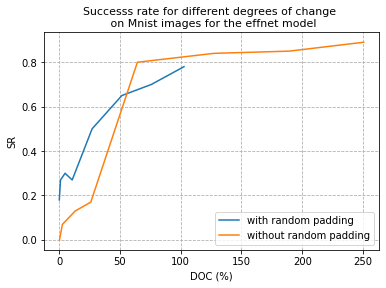

In [17]:
plt.plot(list(SR_FGSM_dic_with_defense.keys()),list(SR_FGSM_dic_with_defense.values()),label='with random padding')
plt.plot(list(SR_FGSM_dic_without_defense.keys()),list(SR_FGSM_dic_without_defense.values()),label='without random padding')
plt.grid(True,which="both", linestyle='--')
plt.title('Successs rate for different degrees of change \n on Mnist images for the effnet model',fontsize=11)
plt.xlabel('DOC (%)')
plt.ylabel('SR')
plt.legend(loc='lower right')

In [ ]:
SR_FGSM_dic_without_defense,SR_FGSM_dic_with_defense=run_white_boxes('Cifar')

In [ ]:
plt.plot(list(SR_FGSM_dic_with_defense.keys()),list(SR_FGSM_dic_with_defense.values()),label='with random padding')
plt.plot(list(SR_FGSM_dic_without_defense.keys()),list(SR_FGSM_dic_without_defense.values()),label='without random padding')
plt.grid(True,which="both", linestyle='--')
plt.title('Successs rate for different degrees of change \n on Cifar images for the effnet model',fontsize=11)
plt.xlabel('DOC (%)')
plt.ylabel('SR')
plt.legend(loc='upper left')

##  5. Defense against black box attacks

#### Model with defense

In [ ]:
(X_train,X_test,y_train,y_test)=pick_data_set('Mnist')
print('====training model without padding====')
model_without_def=train_and_save_effnet('Mnist')
print('====training model with padding====')
model_with_def=create_model_with_defense('Mnist')

In [ ]:
classifier = TensorFlowV2Classifier(model=model_with_def, input_shape=(32,32,3),clip_values=(0, 255),nb_classes=10)
degree_of_change_def={}
attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=0, delta=0.001, epsilon=0.001)
iter_step =1
image_list_def=[]
target=X_test[0]
x_adv = None
for i in range(100):
    x_adv = attack.generate(x=np.array([target]), x_adv_init=x_adv)

    #clear_output()
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target, [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(x_adv[0][..., ::-1].astype('int64'))
    image_list_def.append(x_adv[0][..., ::-1].astype(np.uint))
    plt.show(block=False)
    degree_of_change_def[i * iter_step]=DOC([x_adv[0]],[target])
    
    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step 
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break


#### Model without  defense

In [ ]:
classifier = TensorFlowV2Classifier(model=model_without_def, input_shape=(32,32,3),clip_values=(0, 255),nb_classes=10)
degree_of_change={}
attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=0, delta=0.001, epsilon=0.01)
iter_step =1
image_list=[]
target=X_test[0]
x_adv = None
for i in range(100):
    x_adv = attack.generate(x=np.array([target]), x_adv_init=x_adv)

    #clear_output()
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target, [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(x_adv[0][..., ::-1].astype(np.uint))
    image_list.append(x_adv[0][..., ::-1].astype(np.uint))
    plt.show(block=False)
    degree_of_change[i * iter_step]=DOC([x_adv[0]],[target])
    
    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step 
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break


In [ ]:
plt.plot(list(degree_of_change.keys()),list(degree_of_change.values()),label='DOC without defense')
plt.plot(list(degree_of_change_def.keys()),list(degree_of_change_def.values()),label='DOC with defense')
plt.grid(True,which="both", linestyle='--')
plt.title('DOC of the adversarial image with respect to the number of iterations on EfficientNet on Mnist', fontsize=8)
plt.xlabel('Iterarion')
plt.ylabel('DOC (%)')

plt.legend(loc='upper right')
plt.show()

##### Save images as .gif

In [ ]:
# for i,image in enumerate(image_list_def):
      
#     im=np.array(tf.image.resize(image.astype('uint8'), [200,200], method='nearest', preserve_aspect_ratio=True))
#     im = Image.fromarray(im.astype('uint8'), 'RGB')
#     image_list_def[i]=im

# from PIL import Image
# image_list_def[0].save('attack_with_defense.gif',
#                save_all=True, append_images=image_list_def[1:], optimize=False, duration=40, loop=0)

In [ ]:
# for i,image in enumerate(image_list):
      
#     im=np.array(tf.image.resize(image.astype('uint8'), [200,200], method='nearest', preserve_aspect_ratio=True))
#     im = Image.fromarray(im.astype('uint8'), 'RGB')
#     image_list[i]=im

# from PIL import Image
# image_list[0].save('attack_without_defense.gif',
#                save_all=True, append_images=image_list[1:], optimize=False, duration=40, loop=0)